In [24]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle
import random

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

In [3]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
subjects_to_process = ['01']

In [4]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]


downfreq = 128

In [5]:
#======================================================================================
#                        LOAD FILES
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, 'eeg_error_post_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    events_sv = data['events']

    """  already_processed = []
    already_processed.append(subject_ID)"""


    

Opening eeg_error_post_01.mat


In [6]:
#making raw object from .mat data

info_raw = mne.create_info(ch_names=ch_names_64, sfreq = 128, ch_types='eeg')
raw = mne.io.RawArray(eeg, info = info_raw)
raw.set_montage('biosemi64')


Creating RawArray with float64 data, n_channels=64, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   599.992 secs
Ready.


<RawArray | 64 x 76800 (600.0 s), ~37.6 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


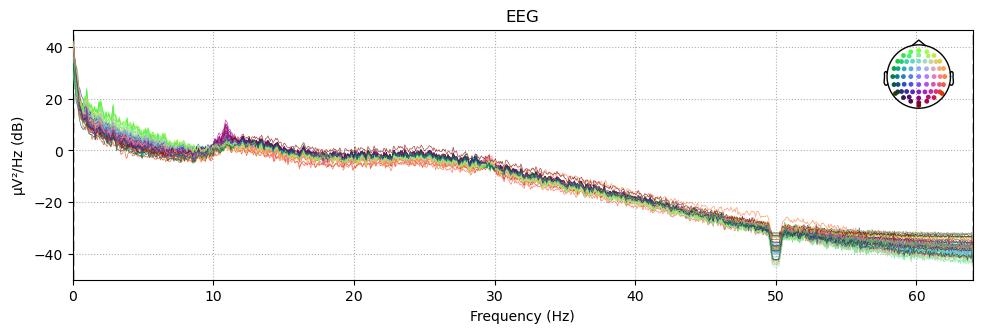

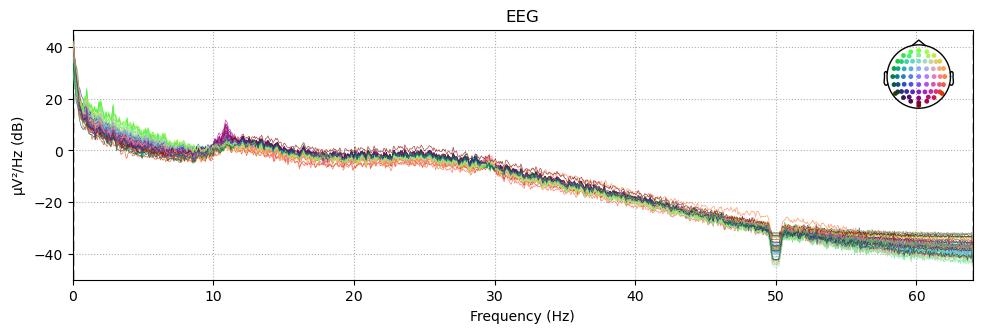

In [7]:
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)

## ICA

In [8]:
ica = ICA(max_iter="auto", random_state=97)
ica.fit(raw)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_80083/3142827221.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components
Fitting ICA took 4.1s.


<ICA | raw data decomposition, method: fastica (fit in 92 iterations on 76800 samples), 64 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

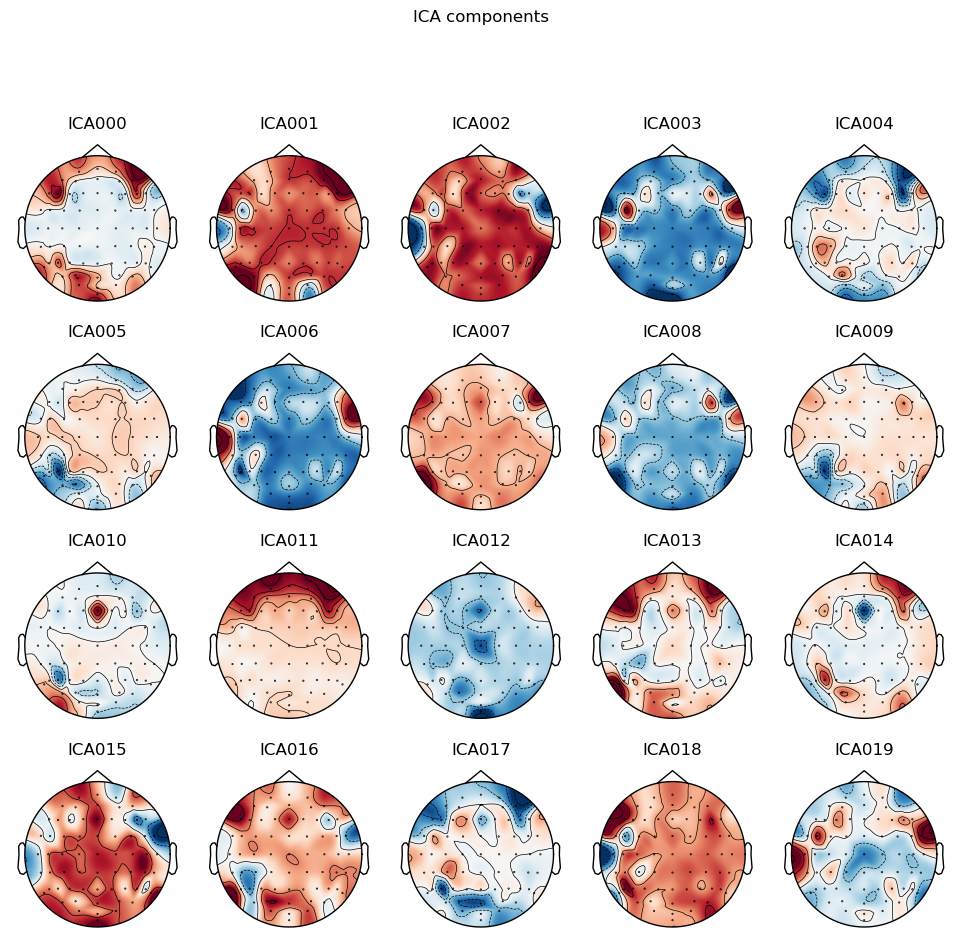

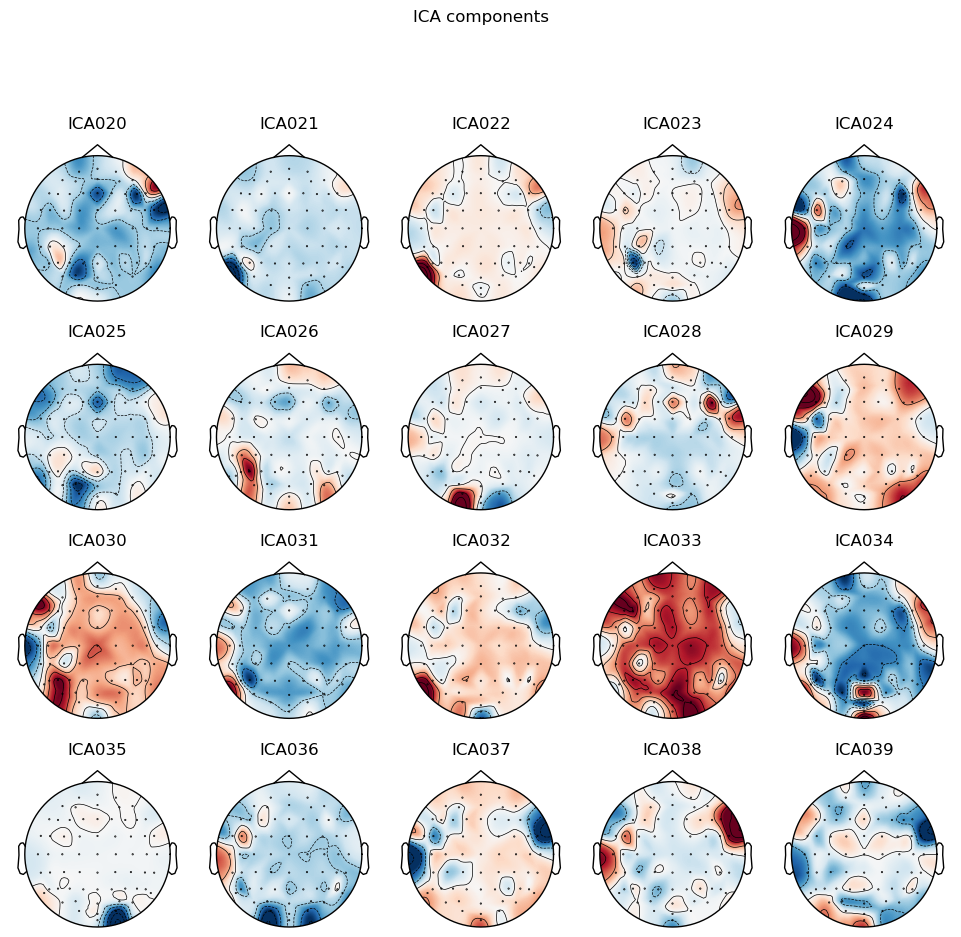

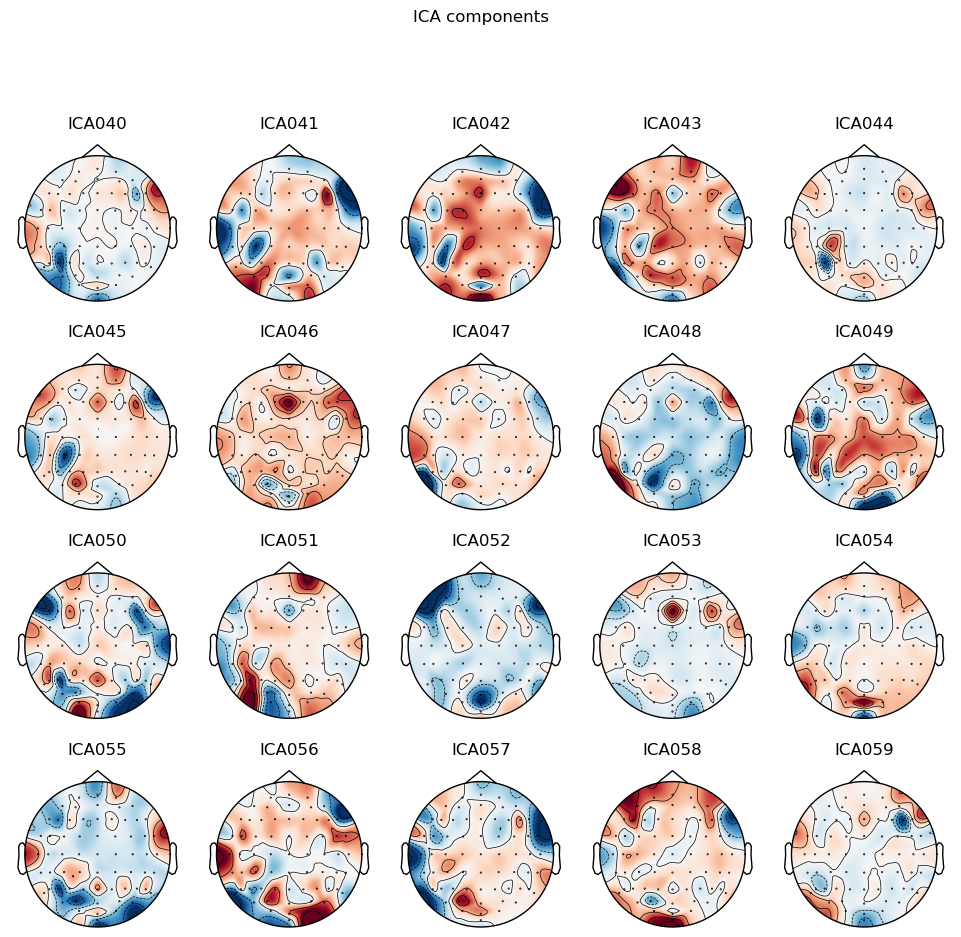

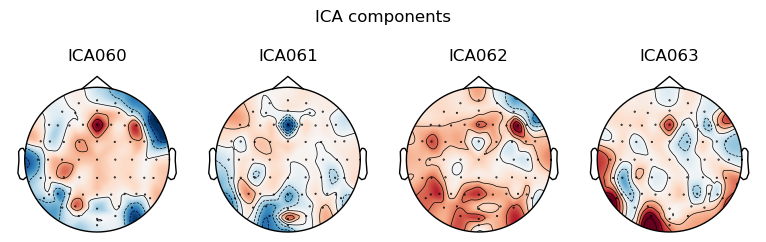

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [9]:
ica.plot_components()

In [10]:
ica.exclude = [0,11]
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<RawArray | 64 x 76800 (600.0 s), ~37.6 MB, data loaded>

## PLOTS

In [11]:
events_arr = make_raw_events(events_sv)
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
t_inv = clean_triggers(events_arr[events_arr[:, 2]==3])
t_shinv = clean_triggers(events_arr[events_arr[:, 2]==4])
t_norm = clean_triggers(events_arr[events_arr[:, 2]==5])
t_modeswitch = np.concatenate([t_inv, t_shinv, t_norm])
t_modeswitch = events_inorder(t_modeswitch)

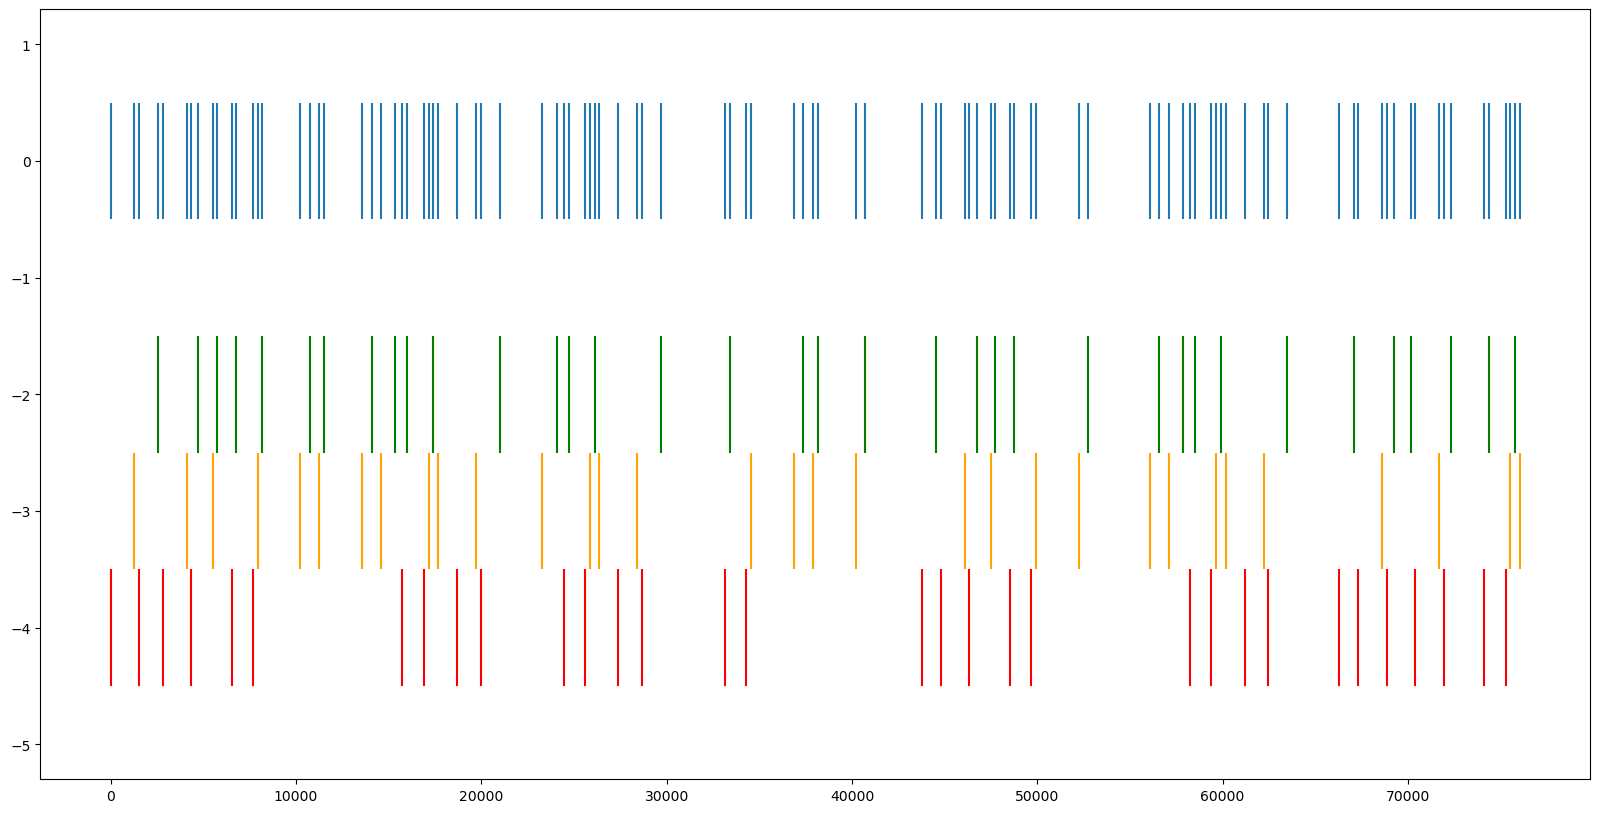

In [12]:
plt.figure(figsize = (20,10))
plt.eventplot(t_modeswitch[:,0], lineoffsets = 0)
plt.eventplot(t_inv[:,0], color = 'green', lineoffsets = -2)
plt.eventplot(t_shinv[:,0], color = 'orange', lineoffsets = -3)
plt.eventplot(t_norm[:,0], color = 'red', lineoffsets=-4)
plt.show()

All keystroke ERPs

Not setting metadata
390 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 390 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


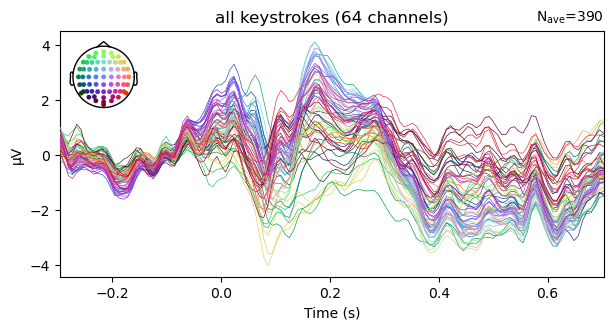

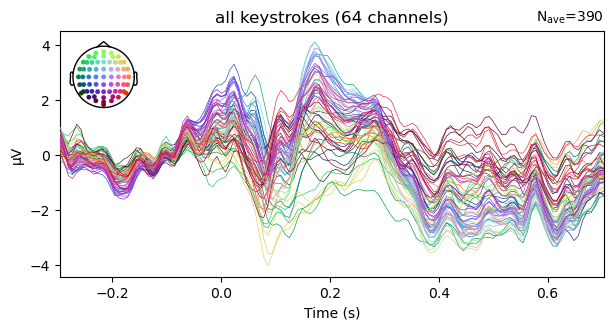

In [13]:
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
#fig = epochs.plot(events=t_keystrokes)
evoked = epochs.average()
evoked.plot(titles='all keystrokes')

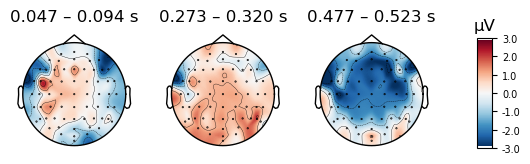

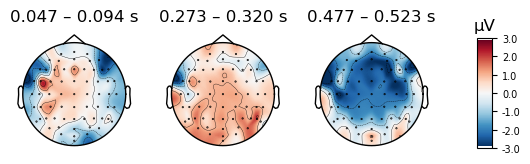

In [14]:
evoked.plot_topomap(times=[0.07, 0.3, 0.5], average=0.05)

Not setting metadata
193 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 193 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


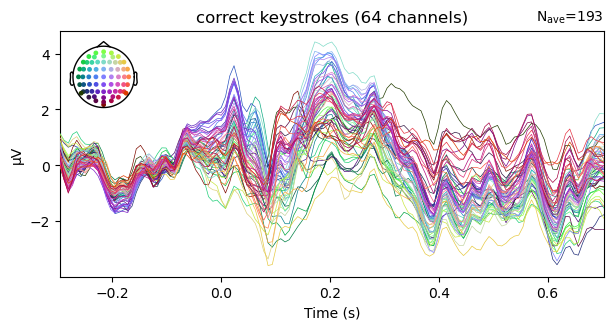

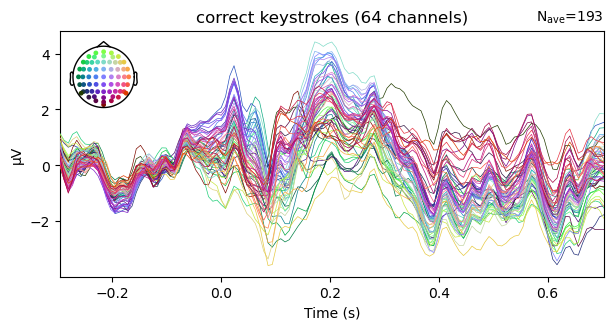

In [16]:
inv_sections = find_sections(reconst_raw, t_inv, t_modeswitch)
inv_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, inv_sections)

epochs_inv = mne.Epochs(reconst_raw, inv_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
inv_evoked = epochs_inv.average()
inv_evoked.plot(titles = 'correct keystrokes')

In [25]:
epochs_inv_sub = random.sample(epochs, 50)
evoked_inv_sub = epochs_inv_sub.average()
evoked_inv_sub.plot()

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

Not setting metadata
96 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


Using data from preloaded Raw for 96 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


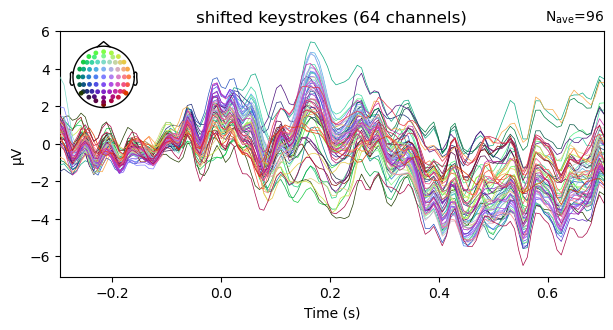

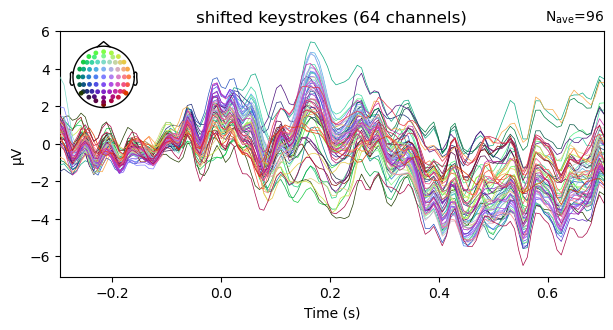

In [160]:
shinv_sections = find_sections(reconst_raw, t_shinv, t_modeswitch)
shinv_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, shinv_sections)

epochs_shinv = mne.Epochs(reconst_raw, shinv_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
shinv_evoked = epochs_shinv.average()
shinv_evoked.plot(titles = 'shifted keystrokes')

Not setting metadata
101 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 101 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


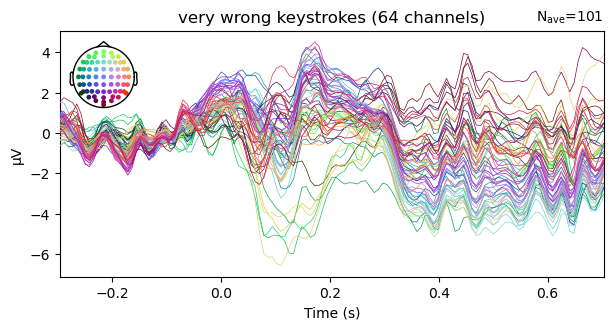

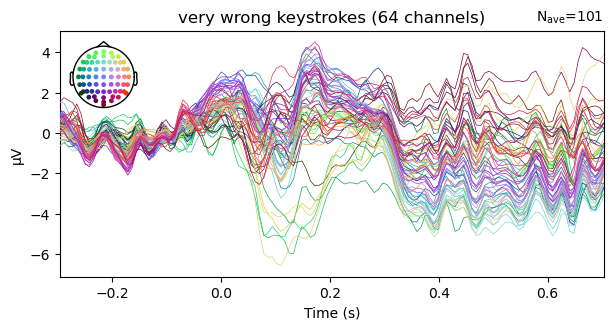

In [161]:
norm_sections = find_sections(reconst_raw, t_norm, t_modeswitch)
norm_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, norm_sections)

epochs_norm = mne.Epochs(reconst_raw, norm_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
norm_evoked = epochs_norm.average()
norm_evoked.plot(titles = 'very wrong keystrokes')

In [162]:
#raw.plot(events = t_keystrokes)

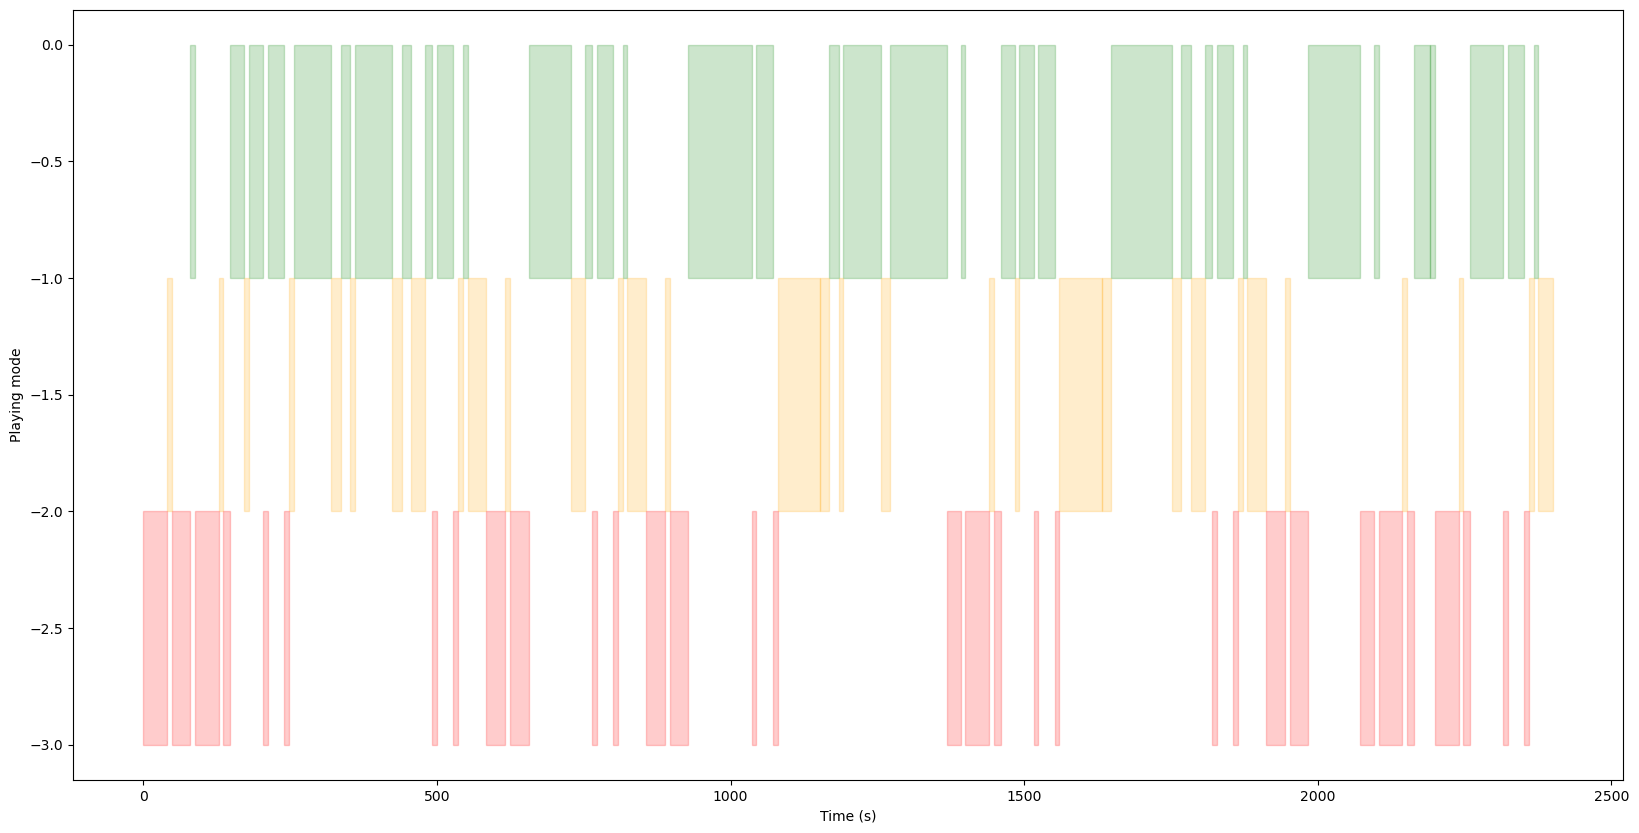

In [163]:


all_sections = [
    inv_sections,
    shinv_sections,
    norm_sections
]
plot_sections(all_sections)


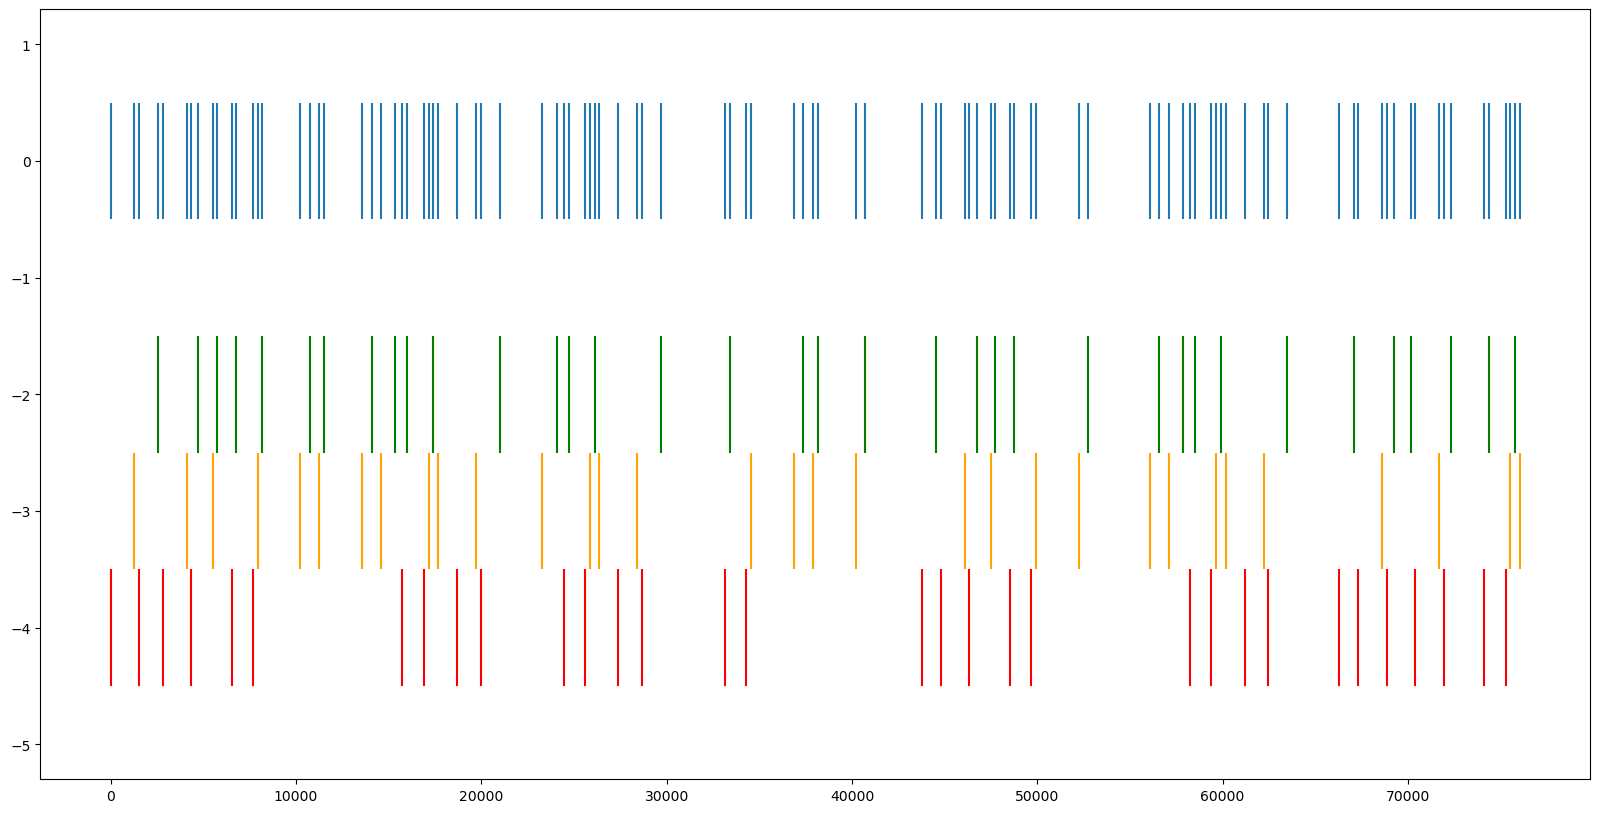

In [164]:
plt.figure(figsize = (20,10))
plt.eventplot(t_modeswitch[:,0], lineoffsets = 0)
plt.eventplot(t_inv[:,0], color = 'green', lineoffsets = -2)
plt.eventplot(t_shinv[:,0], color = 'orange', lineoffsets = -3)
plt.eventplot(t_norm[:,0], color = 'red', lineoffsets=-4)
plt.show()

In [172]:
epochs_inv

<Epochs |  193 events (all good), -0.296875 – 0.703125 s, baseline -0.296875 – 0 s, ~12.2 MB, data loaded,
 '2': 193>

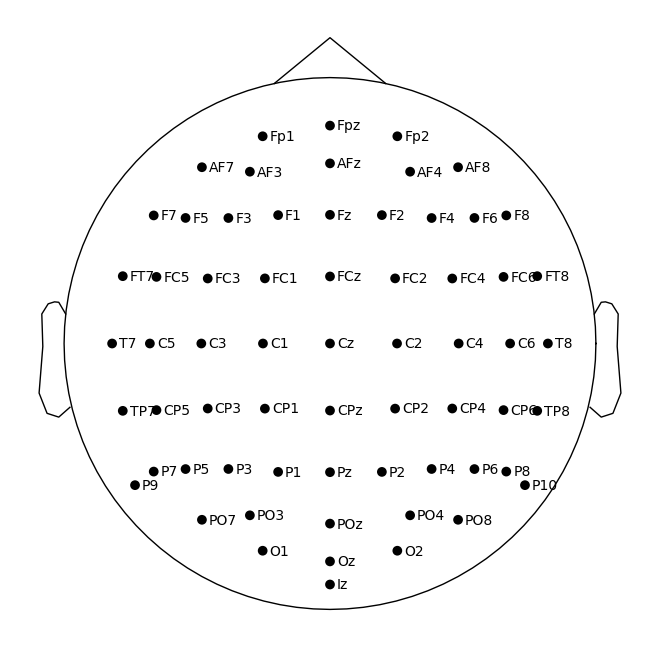

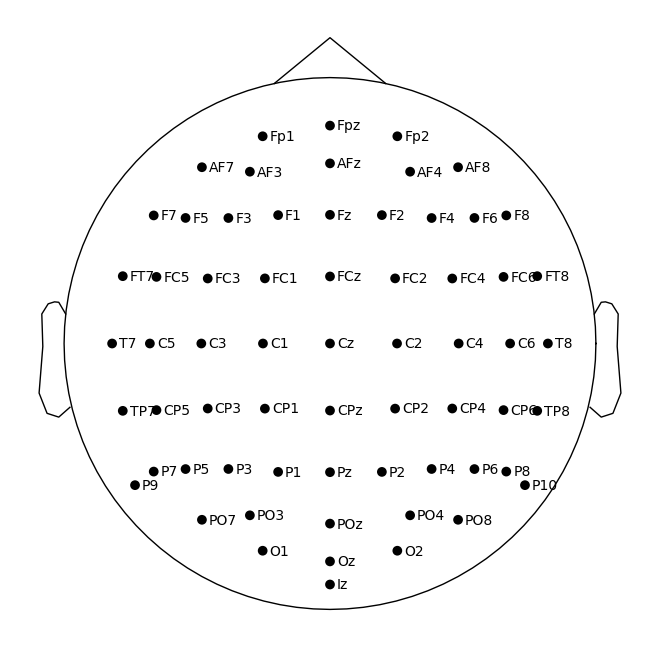

In [187]:
raw.plot_sensors(show_names=True)

In [194]:
erp_ch = ['Cz', 'FCz', 'FC1', 'FC2', 'C1', 'C2']

combining channels using "gfp"
combining channels using "gfp"


combining channels using "gfp"


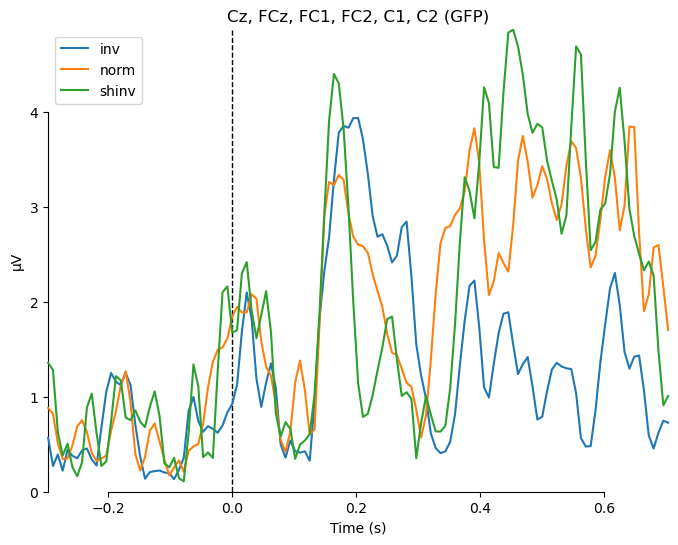

[<Figure size 800x600 with 1 Axes>]

In [195]:
inv_evoked.comment='inv'
norm_evoked.comment = 'norm'
shinv_evoked.comment  = 'shinv'

evokeds = [inv_evoked,norm_evoked, shinv_evoked]
mne.viz.plot_compare_evokeds(evokeds, picks = erp_ch, ci = True)

Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


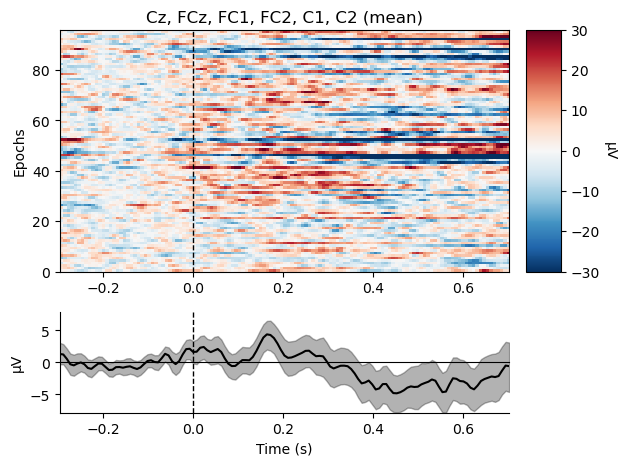

[<Figure size 640x480 with 3 Axes>]

In [204]:
mne.viz.plot_epochs_image(epochs_shinv,picks = erp_ch, combine='mean', vmin = -30, vmax = 30)